## Phase II
### Data Cleaning

#### Name: Everett Meehan

In [ ]:
import requests
import pandas as pd

api_key = "GodjGTNmZedxuPZHaUdqYCBnTjy5Skh8lG7hrOYO"  # Or your key

# Search Foods
url = "https://api.nal.usda.gov/fdc/v1/foods/search"
params = {"query": "superfood", "api_key": api_key}
response = requests.get(url, params=params)
print(response.json())


{'totalHits': 1107, 'currentPage': 1, 'totalPages': 23, 'pageList': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'foodSearchCriteria': {'query': 'superfood', 'generalSearchInput': 'superfood', 'pageNumber': 1, 'numberOfResultsPerPage': 50, 'pageSize': 50, 'requireAllWords': False}, 'foods': [{'fdcId': 168208, 'description': 'Fruit juice smoothie, ODWALLA, ORIGINAL SUPERFOOD', 'commonNames': '', 'additionalDescriptions': '', 'dataType': 'SR Legacy', 'ndbNumber': 9513, 'publishedDate': '2019-04-01', 'foodCategory': 'Fruits and Fruit Juices', 'allHighlightFields': '', 'score': 321.29324, 'microbes': [], 'foodNutrients': [{'nutrientId': 1187, 'nutrientName': 'Folate, food', 'nutrientNumber': '432', 'unitName': 'UG', 'derivationCode': 'A', 'derivationDescription': 'Analytical', 'derivationId': 1, 'value': 14.0, 'foodNutrientSourceId': 1, 'foodNutrientSourceCode': '1', 'foodNutrientSourceDescription': 'Analytical or derived from analytical', 'rank': 7100, 'indentLevel': 1, 'foodNutrientId': 1338174, 'da

In [ ]:
def combine_pages(url, query, key):
  """
  Combine all the pages of data into one dataframe

  Args:
  - url (str): website url
  - query (str): Search Query
  - key (str): Api key

  Returns:
  - df (DataFrame): DataFrame with every page of data

  """
  params = {"query": query,"pageSize":200, "api_key": key}
  response = requests.get(url, params=params)
  pages = response.json()['totalPages']

  df = pd.DataFrame()
  for i in range(pages):
    if i > 25:
      break
    params = {"query": query,"page": i,"pageSize": 200, "api_key": key}
    data = requests.get(url, params=params)
    page = pd.DataFrame(data.json()['foods'])
    df = pd.concat([df,page], axis=0)

  return df

In [ ]:
super_df = combine_pages(url, "superfood", api_key)
super_df.shape

(1200, 32)

In [ ]:
super_df.head()

fdcId                                        description commonNames  \
0   168208  Fruit juice smoothie, ODWALLA, ORIGINAL SUPERFOOD               
1  2665686                  SUPERFOOD VEGGIE CAKES, SUPERFOOD         NaN   
2  2620391     ORGANIC, SUPERFOODS VEGGIE BURGERS, SUPERFOODS         NaN   
3  1882647             SUPERFOOD PESTO SAUCE, SUPERFOOD PESTO         NaN   
4  2145788             SUPERFOOD POWER SALAD, SUPERFOOD POWER         NaN   

  additionalDescriptions   dataType  ndbNumber publishedDate  \
0                         SR Legacy     9513.0    2019-04-01   
1                    NaN    Branded        NaN    2023-11-16   
2                    NaN    Branded        NaN    2023-08-31   
3                    NaN    Branded        NaN    2021-07-29   
4                    NaN    Branded        NaN    2021-10-28   

                                    foodCategory allHighlightFields  \
0                        Fruits and Fruit Juices                      
1  Frozen Breakfast Sandwiches, Biscuits & Meals                      
2                     Frozen Patties and Burgers                      
3                  Prepared Pasta & Pizza Sauces                      
4            Pickles, Olives, Peppers & Relishes                      

        score  ...  marketCountry modifiedDate dataSource  packageWeight  \
0  321.293240  ...            NaN          NaN        NaN            NaN   
1   72.368450  ...  United States   2021-09-07         LI    12 OZ/340 g   
2   48.151413  ...  United States   2023-07-14         LI    10 oz/283 g   
3   48.151413  ...  United States   2018-04-25         LI     7 oz/198 g   
4   48.151413  ...  United States   2019-10-07         LI  9.25 oz/262 g   

  servingSizeUnit servingSize householdServingFullText shortDescription  \
0             NaN         NaN                      NaN              NaN   
1             GRM        57.0                   1 cake                    
2             GRM        71.0                  1 PATTY                    
3               g        62.0                 0.25 cup              NaN   
4               g       100.0                    1 cup              NaN   

        tradeChannels caffeineStatement  
0                 NaN               NaN  
1  [NO_TRADE_CHANNEL]               NaN  
2  [NO_TRADE_CHANNEL]               NaN  
3  [NO_TRADE_CHANNEL]               NaN  
4  [NO_TRADE_CHANNEL]               NaN  

[5 rows x 32 columns]

In [ ]:
def add_nutrients(df):
  """
  extracts nutrition information from foodNutrients dictionary
  and creates new columns

  Args:
  - df (DataFrame): all the food data

  Returns:
  - df (DaataFrame): updated dataframe with nutrition columns
  """
  for index, row in df.iterrows():
      if isinstance(row['foodNutrients'], list):
          fat = 0
          protein = 0
          carbs = 0
          for nutrient_info in row['foodNutrients']:
              nutrient_name = nutrient_info.get('nutrientName')
              nutrient_unit = nutrient_info.get('unitName')
              nutrient_value = nutrient_info.get('value')

              if 'Fatty acids' in nutrient_name:
                fat += nutrient_value
              elif nutrient_name == 'Protein':
                  protein = nutrient_value
              elif nutrient_name == 'Carbohydrate, by difference':
                  carbs = nutrient_value


              if nutrient_name and nutrient_unit:
                  column_name = f'{nutrient_name} ({nutrient_unit})'
                  df.at[index, column_name] = nutrient_value
          df.at[index, 'Total Fat (G)'] = fat
          df.at[index, 'Calories'] = (protein * 4) + (carbs * 4) + (fat * 9)
  return df

In [ ]:
super_df = add_nutrients(super_df)

/tmp/ipython-input-3139376305.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, column_name] = nutrient_value
/tmp/ipython-input-3139376305.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, column_name] = nutrient_value
/tmp/ipython-input-3139376305.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

In [ ]:
super_df.head()

fdcId                                        description commonNames  \
0   168208  Fruit juice smoothie, ODWALLA, ORIGINAL SUPERFOOD               
1  2665686                  SUPERFOOD VEGGIE CAKES, SUPERFOOD         NaN   
2  2620391     ORGANIC, SUPERFOODS VEGGIE BURGERS, SUPERFOODS         NaN   
3  1882647             SUPERFOOD PESTO SAUCE, SUPERFOOD PESTO         NaN   
4  2145788             SUPERFOOD POWER SALAD, SUPERFOOD POWER         NaN   

  additionalDescriptions   dataType  ndbNumber publishedDate  \
0                         SR Legacy     9513.0    2019-04-01   
1                    NaN    Branded        NaN    2023-11-16   
2                    NaN    Branded        NaN    2023-08-31   
3                    NaN    Branded        NaN    2021-07-29   
4                    NaN    Branded        NaN    2021-10-28   

                                    foodCategory allHighlightFields  \
0                        Fruits and Fruit Juices                      
1  Frozen Breakfast Sandwiches, Biscuits & Meals                      
2                     Frozen Patties and Burgers                      
3                  Prepared Pasta & Pizza Sauces                      
4            Pickles, Olives, Peppers & Relishes                      

        score  ... Vitamin K (phylloquinone) (UG) Total Fat (G) Calories  \
0  321.293240  ...                            5.0         0.261   50.869   
1   72.368450  ...                            NaN         0.000   70.040   
2   48.151413  ...                            NaN         1.410  136.810   
3   48.151413  ...                            NaN         7.260  123.420   
4   48.151413  ...                            NaN         0.000   84.000   

  Sugars, added (G) Total sugar alcohols (G)  \
0               NaN                      NaN   
1               1.8                      NaN   
2               0.0                      0.0   
3               NaN                      NaN   
4               3.0                      NaN   

  Vitamin D (D2 + D3), International Units (IU) Pantothenic acid (MG)  \
0                                           NaN                   NaN   
1                                           NaN                   NaN   
2                                           NaN                   NaN   
3                                           NaN                   NaN   
4                                           NaN                   NaN   

  Vitamin E (MG_ATE) Molybdenum, Mo (UG) Vitamin E (MG)  
0                NaN                 NaN            NaN  
1                NaN                 NaN            NaN  
2                NaN                 NaN            NaN  
3                NaN                 NaN            NaN  
4                NaN                 NaN            NaN  

[5 rows x 147 columns]

In [ ]:
print(super_df.columns.tolist())

['fdcId', 'description', 'commonNames', 'additionalDescriptions', 'dataType', 'ndbNumber', 'publishedDate', 'foodCategory', 'allHighlightFields', 'score', 'microbes', 'foodNutrients', 'finalFoodInputFoods', 'foodMeasures', 'foodAttributes', 'foodAttributeTypes', 'foodVersionIds', 'gtinUpc', 'brandOwner', 'brandName', 'subbrandName', 'ingredients', 'marketCountry', 'modifiedDate', 'dataSource', 'packageWeight', 'servingSizeUnit', 'servingSize', 'householdServingFullText', 'shortDescription', 'tradeChannels', 'caffeineStatement', 'Folate, food (UG)', 'Vitamin B-12, added (UG)', 'Cholesterol (MG)', 'Fatty acids, total trans (G)', 'Fatty acids, total saturated (G)', 'SFA 8:0 (G)', 'SFA 12:0 (G)', 'SFA 14:0 (G)', 'Vitamin A, RAE (UG)', 'Carotene, beta (UG)', 'Carotene, alpha (UG)', 'Vitamin D (D2 + D3) (UG)', 'Cryptoxanthin, beta (UG)', 'Lycopene (UG)', 'Vitamin C, total ascorbic acid (MG)', 'Thiamin (MG)', 'Riboflavin (MG)', 'Folate, total (UG)', 'Vitamin B-12 (UG)', 'Protein (G)', 'Ash (G

In [ ]:
def clean(df):
  """
  Cleans out the dataframe

  Args:
  - df (DataFrame): Food dataframe

  Returns:
  - df_cleaned (DataFrame): cleaned dataframe
  """
  macros = ['Protein (G)', 'Carbohydrate, by difference (G)', 'Total Fat (G)', 'Calories']
  df_cleaned = df.dropna(subset = macros)
  micro_nulls_per_row = df_cleaned.iloc[:,32:147].isnull().sum(axis=1)
  df_cleaned['<40% micronutrients completeness'] = (micro_nulls_per_row / 114) < 0.4
  df_cleaned = df_cleaned[df_cleaned['<40% micronutrients completeness'] == False]
  df_cleaned.drop_duplicates(subset=['description'], inplace=True)

  return df_cleaned

In [ ]:
super_cleaned = clean(super_df)
super_cleaned.shape

/tmp/ipython-input-399118614.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['<40% micronutrients completeness'] = (micro_nulls_per_row / 114) < 0.4
/tmp/ipython-input-399118614.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['<40% micronutrients completeness'] = (micro_nulls_per_row / 114) < 0.4


(175, 148)

In [ ]:
super_cleaned.to_csv('superfoods_tagged.csv', index=False)

In [ ]:
api_key = "GodjGTNmZedxuPZHaUdqYCBnTjy5Skh8lG7hrOYO"  # Or your key

# Search Foods
url = "https://api.nal.usda.gov/fdc/v1/foods/search"
params = {"query": "food","pagesize":200, "api_key": api_key}
response = requests.get(url, params=params)
print(response.json())

{'totalHits': 114343, 'currentPage': 1, 'totalPages': 2287, 'pageList': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'foodSearchCriteria': {'query': 'food', 'generalSearchInput': 'food', 'pageNumber': 1, 'numberOfResultsPerPage': 50, 'pageSize': 50, 'requireAllWords': False}, 'foods': [{'fdcId': 588394, 'description': 'FOOD', 'dataType': 'Branded', 'gtinUpc': '8997210211017', 'publishedDate': '2019-04-01', 'brandOwner': 'GOLDEN SEAHORSE', 'ingredients': 'SHRIMP, SALT AND SODIUM TRIPOLYPHOSPHATE (FOR MOISTURE RETENTION)', 'marketCountry': 'United States', 'foodCategory': 'Frozen Fish & Seafood', 'modifiedDate': '2018-07-06', 'dataSource': 'LI', 'servingSizeUnit': 'g', 'servingSize': 85.0, 'householdServingFullText': '3 ONZ', 'tradeChannels': ['NO_TRADE_CHANNEL'], 'allHighlightFields': '', 'score': 1221.0885, 'microbes': [], 'foodNutrients': [{'nutrientId': 1005, 'nutrientName': 'Carbohydrate, by difference', 'nutrientNumber': '205', 'unitName': 'G', 'derivationCode': 'LCCD', 'derivationDescription'

In [ ]:
other_df = combine_pages(url, "food", api_key)
other_df.head()

fdcId                                        description      dataType  \
0   588394                                               FOOD       Branded   
1   169705  Oats (Includes foods for USDA's Food Distribut...     SR Legacy   
2  2644260  The Development of the Davis Food Glycopedia—A...  Experimental   
3   170302                                 Fast food, biscuit     SR Legacy   
4   170300                               Fast foods, coleslaw     SR Legacy   

         gtinUpc publishedDate       brandOwner  \
0  8997210211017    2019-04-01  GOLDEN SEAHORSE   
1            NaN    2019-04-01              NaN   
2            NaN    2023-10-26              NaN   
3            NaN    2019-04-01              NaN   
4            NaN    2019-04-01              NaN   

                                         ingredients  marketCountry  \
0  SHRIMP, SALT AND SODIUM TRIPOLYPHOSPHATE (FOR ...  United States   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                                NaN            NaN   

              foodCategory modifiedDate  ... foodAttributes  \
0    Frozen Fish & Seafood   2018-07-06  ...             []   
1  Cereal Grains and Pasta          NaN  ...             []   
2                      NaN          NaN  ...             []   
3               Fast Foods          NaN  ...             []   
4               Fast Foods          NaN  ...             []   

  foodAttributeTypes  foodVersionIds   scientificName commonNames  \
0                 []              []              NaN         NaN   
1                 []              []  Avena sativa L.               
2                 []              []              NaN         NaN   
3                 []              []              NaN               
4                 []              []              NaN               

  additionalDescriptions  ndbNumber                       tags foodCode  \
0                    NaN        NaN                        NaN      NaN   
1                           20038.0                        NaN      NaN   
2                    NaN        NaN  [Database, USDA Research]      NaN   
3                           21142.0                        NaN      NaN   
4                           21127.0                        NaN      NaN   

  foodCategoryId  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 31 columns]

In [ ]:
other_df.shape

(5200, 31)

In [ ]:
other_df = add_nutrients(other_df)
other_df.head()

/tmp/ipython-input-3139376305.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, column_name] = nutrient_value
/tmp/ipython-input-3139376305.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, column_name] = nutrient_value
/tmp/ipython-input-3139376305.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

fdcId                                        description      dataType  \
0   588394                                               FOOD       Branded   
1   169705  Oats (Includes foods for USDA's Food Distribut...     SR Legacy   
2  2644260  The Development of the Davis Food Glycopedia—A...  Experimental   
3   170302                                 Fast food, biscuit     SR Legacy   
4   170300                               Fast foods, coleslaw     SR Legacy   

         gtinUpc publishedDate       brandOwner  \
0  8997210211017    2019-04-01  GOLDEN SEAHORSE   
1            NaN    2019-04-01              NaN   
2            NaN    2023-10-26              NaN   
3            NaN    2019-04-01              NaN   
4            NaN    2019-04-01              NaN   

                                         ingredients  marketCountry  \
0  SHRIMP, SALT AND SODIUM TRIPOLYPHOSPHATE (FOR ...  United States   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                                NaN            NaN   

              foodCategory modifiedDate  ... PUFA 20:4 n-6 (G) PUFA 21:5 (G)  \
0    Frozen Fish & Seafood   2018-07-06  ...               NaN           NaN   
1  Cereal Grains and Pasta          NaN  ...               NaN           NaN   
2                      NaN          NaN  ...               NaN           NaN   
3               Fast Foods          NaN  ...               NaN           NaN   
4               Fast Foods          NaN  ...               NaN           NaN   

   Hydroxyproline (G) SFA 13:0 (G) Vitamin D2 (ergocalciferol) (UG)  \
0                 NaN          NaN                              NaN   
1                 NaN          NaN                              NaN   
2                 NaN          NaN                              NaN   
3                 NaN          NaN                              NaN   
4                 NaN          NaN                              NaN   

  TFA 18:2 t,t (G)  Campesterol (MG) Stigmasterol (MG) Beta-sitosterol (MG)  \
0              NaN               NaN               NaN                  NaN   
1              NaN               NaN               NaN                  NaN   
2              NaN               NaN               NaN                  NaN   
3              NaN               NaN               NaN                  NaN   
4              NaN               NaN               NaN                  NaN   

  PUFA 18:2 i (G)  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 181 columns]

In [ ]:
other_cleaned = clean(other_df)
other_cleaned.shape

/tmp/ipython-input-399118614.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['<40% micronutrients completeness'] = (micro_nulls_per_row / 114) < 0.4
/tmp/ipython-input-399118614.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['<40% micronutrients completeness'] = (micro_nulls_per_row / 114) < 0.4


(95, 182)

In [ ]:
other_cleaned.to_csv("Foods_tagged", index=False)

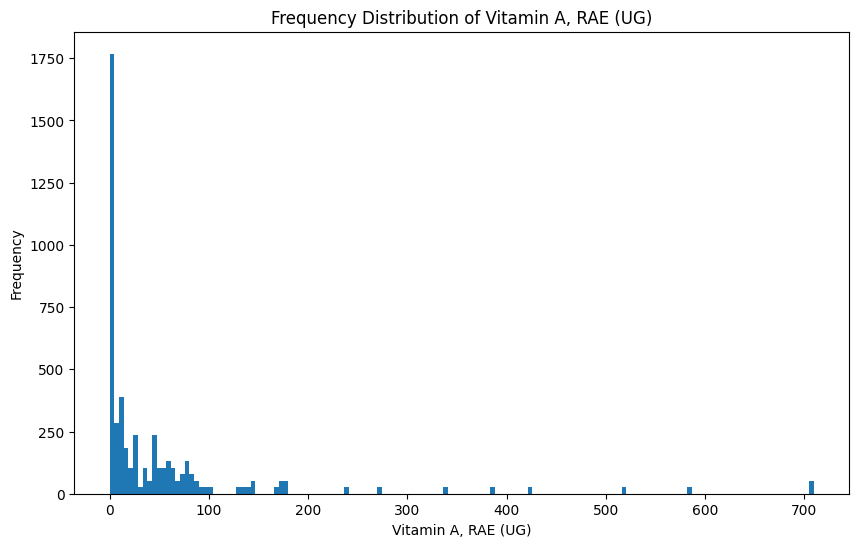

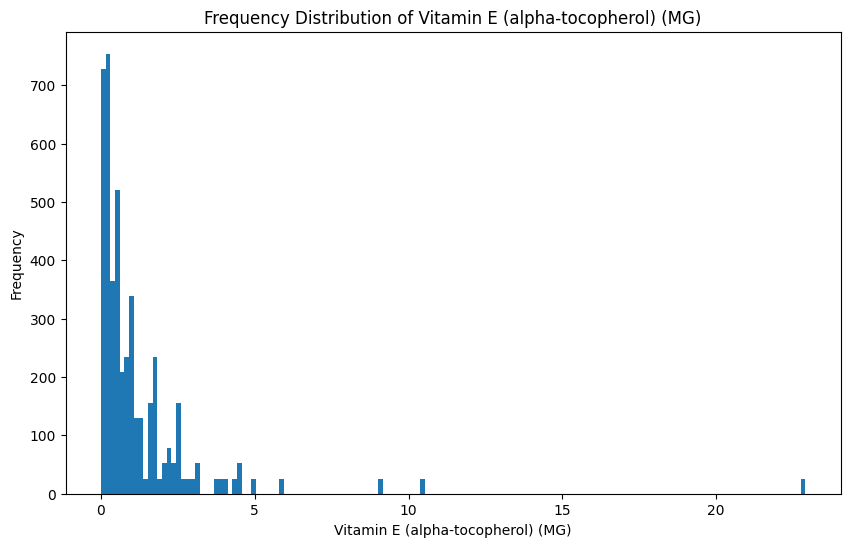

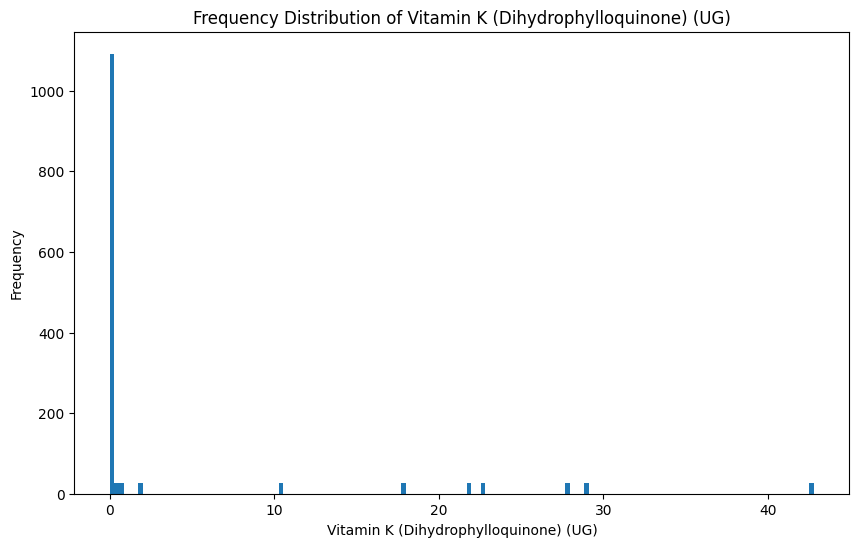

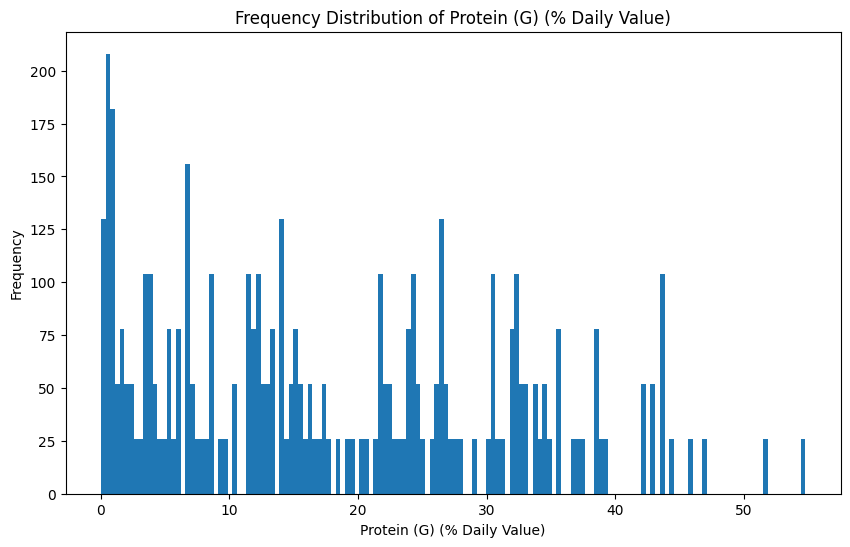

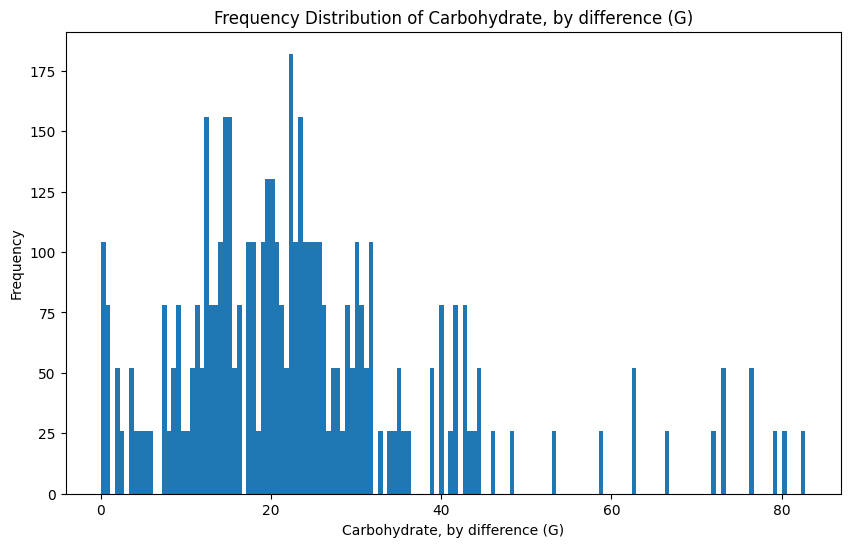

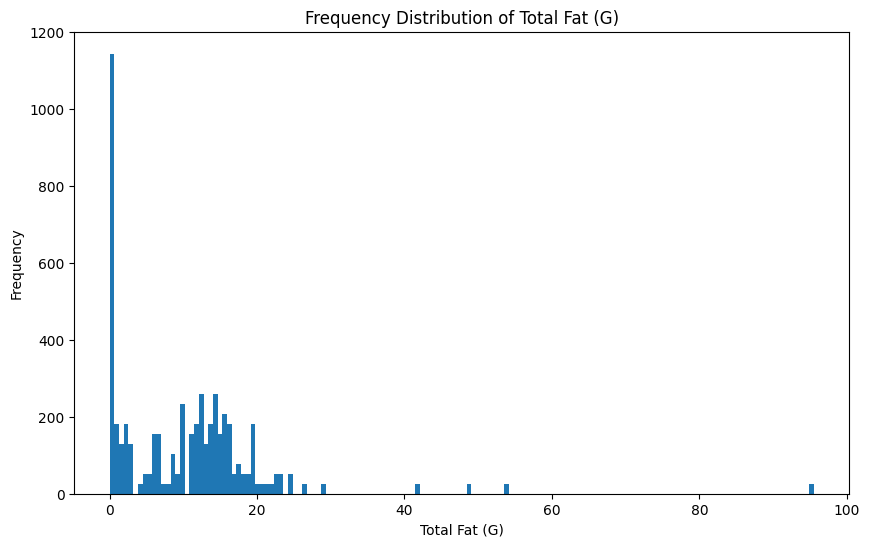

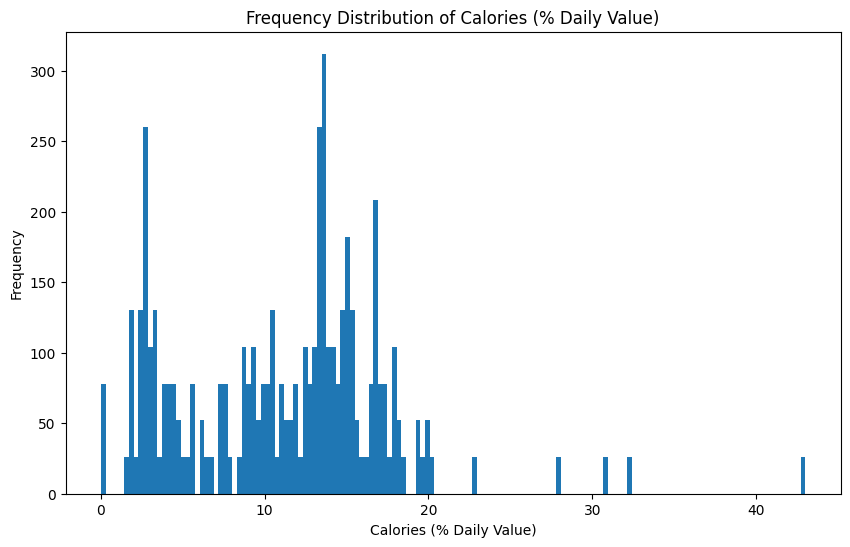

In [ ]:
import matplotlib.pyplot as plt

def plotting_key_nutrients(df, nutrient):
  """
  Plots the distribution of a specified nutrient.

  Args:
  - df (DataFrame): Food dataframe.
  - nutrient (str): The partial name of the nutrient to plot (e.g., "Vitamin C").
  """
  # Find the column that contains the nutrient name
  nutrient_column = None
  for col in df.columns:
    if nutrient.lower() in col.lower():
      nutrient_column = col

  if nutrient_column:
    plt.figure(figsize=(10, 6))
    plt.hist(df[nutrient_column].dropna(), bins=150)
    plt.xlabel(nutrient_column)
    plt.ylabel('Frequency')
    plt.title(f'Frequency Distribution of {nutrient_column}')
    plt.show()
  else:
    print(f"Nutrient '{nutrient}' not found in DataFrame columns.")
plotting_key_nutrients(other_df,'Vitamin A')
plotting_key_nutrients(other_df,'Vitamin E')
plotting_key_nutrients(other_df,'Vitamin K')
plotting_key_nutrients(other_df,'Protein')
plotting_key_nutrients(other_df,'Carbohydrate, by difference')
plotting_key_nutrients(other_df,'Total Fat')
plotting_key_nutrients(other_df,'Calories')

In [ ]:
daily_values = {
    # Macronutrients
    'protein': 50,
    'total_fat': 78,
    'saturated_fat': 20,
    'trans_fat': 0,
    'cholesterol': 300,
    'total_carbohydrate': 275,
    'dietary_fiber': 28,
    'total_sugars': None,
    'added_sugars': 50,

    # Vitamins
    'vitamin_a': 900,
    'vitamin_c': 90,
    'vitamin_d': 20,
    'vitamin_e': 15,
    'vitamin_k': 120,
    'thiamin': 1.2,
    'riboflavin': 1.3,
    'niacin': 16,
    'vitamin_b6': 1.7,
    'folate': 400,
    'vitamin_b12': 2.4,
    'biotin': 30,
    'pantothenic_acid': 5,
    'choline': 550,

    # Minerals
    'calcium': 1300,
    'iron': 18,
    'phosphorus': 1250,
    'iodine': 150,
    'magnesium': 420,
    'zinc': 11,
    'selenium': 55,
    'copper': 0.9,
    'manganese': 2.3,
    'chromium': 35,
    'molybdenum': 45,
    'chloride': 2300,
    'potassium': 4700,
    'sodium': 2300,

    #Calories
    'calories': 2000,
}

other_df.head()


fdcId                                        description      dataType  \
0   588394                                               FOOD       Branded   
1   169705  Oats (Includes foods for USDA's Food Distribut...     SR Legacy   
2  2644260  The Development of the Davis Food Glycopedia—A...  Experimental   
3   170302                                 Fast food, biscuit     SR Legacy   
4   170300                               Fast foods, coleslaw     SR Legacy   

         gtinUpc publishedDate       brandOwner  \
0  8997210211017    2019-04-01  GOLDEN SEAHORSE   
1            NaN    2019-04-01              NaN   
2            NaN    2023-10-26              NaN   
3            NaN    2019-04-01              NaN   
4            NaN    2019-04-01              NaN   

                                         ingredients  marketCountry  \
0  SHRIMP, SALT AND SODIUM TRIPOLYPHOSPHATE (FOR ...  United States   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                                NaN            NaN   

              foodCategory modifiedDate  ... PUFA 20:4 n-6 (G) PUFA 21:5 (G)  \
0    Frozen Fish & Seafood   2018-07-06  ...               NaN           NaN   
1  Cereal Grains and Pasta          NaN  ...               NaN           NaN   
2                      NaN          NaN  ...               NaN           NaN   
3               Fast Foods          NaN  ...               NaN           NaN   
4               Fast Foods          NaN  ...               NaN           NaN   

   Hydroxyproline (G) SFA 13:0 (G) Vitamin D2 (ergocalciferol) (UG)  \
0                 NaN          NaN                              NaN   
1                 NaN          NaN                              NaN   
2                 NaN          NaN                              NaN   
3                 NaN          NaN                              NaN   
4                 NaN          NaN                              NaN   

  TFA 18:2 t,t (G)  Campesterol (MG) Stigmasterol (MG) Beta-sitosterol (MG)  \
0              NaN               NaN               NaN                  NaN   
1              NaN               NaN               NaN                  NaN   
2              NaN               NaN               NaN                  NaN   
3              NaN               NaN               NaN                  NaN   
4              NaN               NaN               NaN                  NaN   

  PUFA 18:2 i (G)  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 181 columns]

In [ ]:
for nutrient, value in daily_values.items():
    nutrient_column = None
    for col in other_cleaned.columns:
      if nutrient.lower() in col.lower():
        nutrient_column = col
        break

    if nutrient_column and value is not None:
        new_column_name = f'{nutrient_column} (% Daily Value)'
        if new_column_name not in other_cleaned.columns:
            other_cleaned[new_column_name] = (other_cleaned[nutrient_column] / value) * 100

# Create a list of columns that represent percentage daily values, excluding calories
percentage_columns = [col for col in other_cleaned.columns if col.endswith('(% Daily Value)') and 'Calories' not in col]

# Cap out the columns at 100% of daily value to prevent skewing of nutrient density
capped_percentages = other_cleaned[percentage_columns].clip(upper=100)

# Calculate the sum of these columns
other_cleaned['Total Nutrient % Daily Value'] = capped_percentages.sum(axis=1)
# Calculate Nutrient Density
other_cleaned['Nutrient Density Score'] = other_cleaned['Total Nutrient % Daily Value'] / other_cleaned['Calories']

In [ ]:
other_df.head()

fdcId                                        description      dataType  \
0   588394                                               FOOD       Branded   
1   169705  Oats (Includes foods for USDA's Food Distribut...     SR Legacy   
2  2644260  The Development of the Davis Food Glycopedia—A...  Experimental   
3   170302                                 Fast food, biscuit     SR Legacy   
4   170300                               Fast foods, coleslaw     SR Legacy   

         gtinUpc publishedDate       brandOwner  \
0  8997210211017    2019-04-01  GOLDEN SEAHORSE   
1            NaN    2019-04-01              NaN   
2            NaN    2023-10-26              NaN   
3            NaN    2019-04-01              NaN   
4            NaN    2019-04-01              NaN   

                                         ingredients  marketCountry  \
0  SHRIMP, SALT AND SODIUM TRIPOLYPHOSPHATE (FOR ...  United States   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                                NaN            NaN   

              foodCategory modifiedDate  ...  \
0    Frozen Fish & Seafood   2018-07-06  ...   
1  Cereal Grains and Pasta          NaN  ...   
2                      NaN          NaN  ...   
3               Fast Foods          NaN  ...   
4               Fast Foods          NaN  ...   

  Magnesium, Mg (MG) (% Daily Value) Zinc, Zn (MG) (% Daily Value)  \
0                                NaN                           NaN   
1                          42.142857                     36.090909   
2                                NaN                           NaN   
3                           3.571429                      4.545455   
4                           1.904762                      1.272727   

   Selenium, Se (UG) (% Daily Value) Copper, Cu (MG) (% Daily Value)  \
0                                NaN                             NaN   
1                                NaN                       69.555556   
2                                NaN                             NaN   
3                               22.0                        9.000000   
4                                NaN                        1.666667   

  Manganese, Mn (MG) (% Daily Value) Potassium, K (MG) (% Daily Value)  \
0                                NaN                               NaN   
1                         213.913043                          9.127660   
2                                NaN                               NaN   
3                          16.869565                          2.787234   
4                           4.434783                          2.744681   

   Sodium, Na (MG) (% Daily Value) Calories (% Daily Value)  \
0                         8.173913                   7.3000   
1                         0.086957                  19.3130   
2                              NaN                   0.0000   
3                        42.565217                  17.5837   
4                         8.826087                   7.5323   

  Total Nutrient % Daily Value Nutrient Density Score  
0                   143.922631               0.985771  
1                   571.214941               1.478835  
2                     0.000000                    NaN  
3                   288.444162               0.820203  
4                    34.205582               0.227059  

[5 rows x 201 columns]

In [ ]:
for nutrient, value in daily_values.items():
    nutrient_column = None
    for col in super_cleaned.columns:
      if nutrient.lower() in col.lower():
        nutrient_column = col
        break

    if nutrient_column and value is not None:
        new_column_name = f'{nutrient_column} (% Daily Value)'
        if new_column_name not in super_cleaned.columns:
            super_cleaned[new_column_name] = (super_cleaned[nutrient_column] / value) * 100

percentage_columns = [col for col in super_cleaned.columns if col.endswith('(% Daily Value)') and 'Calories' not in col]

capped_percentages = super_cleaned[percentage_columns].clip(upper=100)

super_cleaned['Total Nutrient % Daily Value'] = capped_percentages.sum(axis=1)

super_cleaned['Nutrient Density Score'] = super_cleaned['Total Nutrient % Daily Value'] / super_cleaned['Calories']

In [ ]:
super_df.head()

fdcId                                        description commonNames  \
0   168208  Fruit juice smoothie, ODWALLA, ORIGINAL SUPERFOOD               
1  2665686                  SUPERFOOD VEGGIE CAKES, SUPERFOOD         NaN   
2  2620391     ORGANIC, SUPERFOODS VEGGIE BURGERS, SUPERFOODS         NaN   
3  1882647             SUPERFOOD PESTO SAUCE, SUPERFOOD PESTO         NaN   
4  2145788             SUPERFOOD POWER SALAD, SUPERFOOD POWER         NaN   

  additionalDescriptions   dataType  ndbNumber publishedDate  \
0                         SR Legacy     9513.0    2019-04-01   
1                    NaN    Branded        NaN    2023-11-16   
2                    NaN    Branded        NaN    2023-08-31   
3                    NaN    Branded        NaN    2021-07-29   
4                    NaN    Branded        NaN    2021-10-28   

                                    foodCategory allHighlightFields  \
0                        Fruits and Fruit Juices                      
1  Frozen Breakfast Sandwiches, Biscuits & Meals                      
2                     Frozen Patties and Burgers                      
3                  Prepared Pasta & Pizza Sauces                      
4            Pickles, Olives, Peppers & Relishes                      

        score  ... Zinc, Zn (MG) (% Daily Value)  \
0  321.293240  ...                      0.545455   
1   72.368450  ...                           NaN   
2   48.151413  ...                           NaN   
3   48.151413  ...                           NaN   
4   48.151413  ...                           NaN   

  Selenium, Se (UG) (% Daily Value) Copper, Cu (MG) (% Daily Value)  \
0                          0.545455                        4.444444   
1                               NaN                             NaN   
2                               NaN                             NaN   
3                               NaN                             NaN   
4                               NaN                             NaN   

  Manganese, Mn (MG) (% Daily Value) Molybdenum, Mo (UG) (% Daily Value)  \
0                           3.304348                                 NaN   
1                                NaN                                 NaN   
2                                NaN                                 NaN   
3                                NaN                                 NaN   
4                                NaN                                 NaN   

  Potassium, K (MG) (% Daily Value) Sodium, Na (MG) (% Daily Value)  \
0                          3.085106                        0.130435   
1                          3.127660                        6.086957   
2                          5.085106                       19.608696   
3                               NaN                       28.739130   
4                          3.446809                        3.478261   

  Calories (% Daily Value) Total Nutrient % Daily Value Nutrient Density Score  
0                  2.54345                    38.041197               0.747827  
1                  3.50200                    33.208975               0.474143  
2                  6.84050                    47.017905               0.343673  
3                  6.17100                   102.445284               0.830054  
4                  4.20000                    22.172933               0.263963  

[5 rows x 168 columns]

Mean of Nutrient Density Score: 0.7787241368409419
Median of Nutrient Density Score: 0.7804384090519939
Top 20 Foods by Nutrient Density Score:
Blueberries, wild, frozen (Includes foods for USDA's Food Distribution Program): 2.5954357742623273
Egg, whole, fried, from fast food / restaurant: 1.9475945829240133
Pasta, whole grain, 51% whole wheat, remaining enriched semolina, cooked (Includes foods for USDA's Food Distribution Program): 1.5485160944528278
Cheese, processed cheese food: 1.4542451530719567
Oats (Includes foods for USDA's Food Distribution Program): 1.4428154540652371
Chicken fillet sandwich, grilled, from fast food: 1.4215292754553763
Jai, Monk's Food: 1.2926232888115496
Fish sandwich, fried, from fast food: 1.1283250786970893
Fish sandwich, fried, from fast food, with cheese: 1.1278158294188478
Breading or batter as ingredient in food: 1.1035439504523628
Cheeseburger, from fast food, 1 large patty: 1.086149388113042
Cheeseburger, from fast food, 1 medium patty: 1.08075914

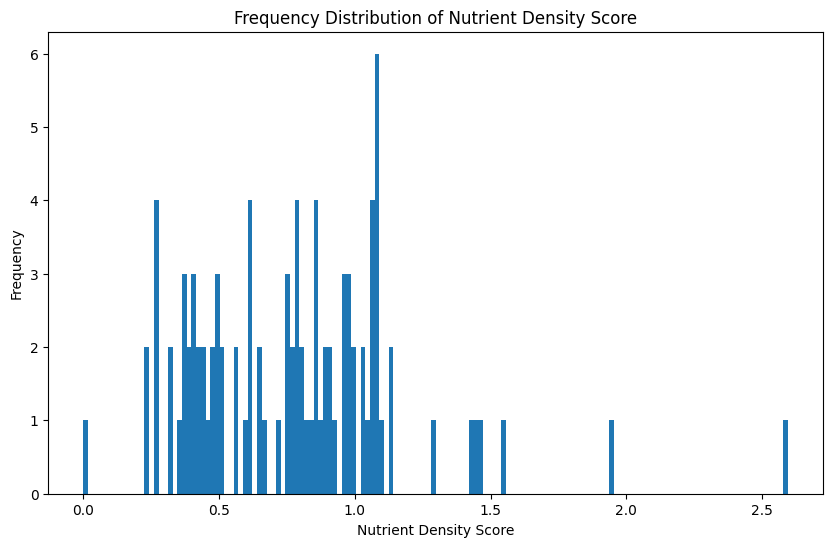

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(other_cleaned['Nutrient Density Score'], bins=150)
plt.xlabel('Nutrient Density Score')
plt.ylabel('Frequency')
plt.title(f'Frequency Distribution of Nutrient Density Score')
plt.show
print(f'Mean of Nutrient Density Score: {other_cleaned["Nutrient Density Score"].mean()}')
print(f'Median of Nutrient Density Score: {other_cleaned["Nutrient Density Score"].median()}')

top_20_foods = other_cleaned.sort_values(by='Nutrient Density Score', ascending=False).head(20)
print("Top 20 Foods by Nutrient Density Score:")
for index, row in top_20_foods.iterrows():
    print(f"{row['description']}: {row['Nutrient Density Score']}")

Mean of Nutrient Density Score: 1.281212277484595
Median of Nutrient Density Score: 0.23986094030883767
Top 20 Foods by Nutrient Density Score:
CERTIFIED ITALIAN SUPERFOOD, RADICCHIO: 86.12176373152322
BUTTER SUPERFOOD TOPPING, BUTTER: 40.64231465997771
ORGANIC SUPERFOOD BLEND: 8.95502294883655
LIVFIT SUPERFOOD PROTEIN BLEND: 7.661376266172151
HEMP PROTEIN SUPERFOODS: 5.798445050440351
NUTRITIONAL YEAST SUPERFOODS: 4.24617877037692
100% ORGANIC MORINGA SUPERFOOD POWDER: 3.371794871794872
CHLORELLA 1000MG GREEN SUPERFOOD: 3.2594278283485045
MORINGA 100% ORGANIC SUPERFOOD POWDER: 2.5384615384615388
HEMP KASHMIR PROTEIN POWDER SUPERFOOD: 2.494824662877253
COCOTROPIC WILD SUPERFOOD ELIXIR: 1.9240174828965968
SUPERFOOD ENERGY BAR, OATMEAL: 1.6384760834446523
ORGANIC SUPERFOOD BOOSTER WHEATGRASS POWDER: 1.4574002238202053
MORINGA SUPERFOOD POWDER: 1.3920531005637389
SUNFLOWER PROTEIN & SUPERFOODS, CHOCOLATE: 1.333578800833347
SUNFLOWER PROTEIN & SUPERFOODS, VANILLA: 1.3298033614253912
BERRY 

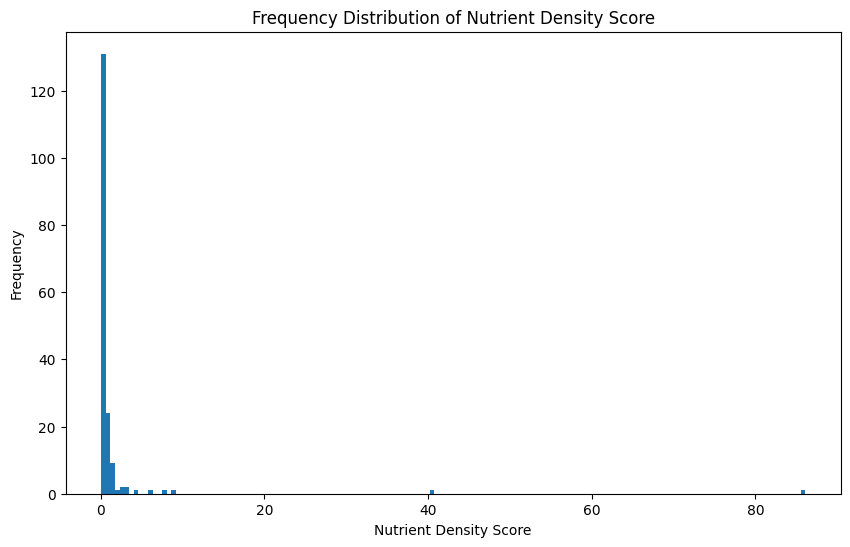

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(super_cleaned['Nutrient Density Score'], bins=150)
plt.xlabel('Nutrient Density Score')
plt.ylabel('Frequency')
plt.title(f'Frequency Distribution of Nutrient Density Score')
plt.show
print(f'Mean of Nutrient Density Score: {super_cleaned["Nutrient Density Score"].mean()}')
print(f'Median of Nutrient Density Score: {super_cleaned["Nutrient Density Score"].median()}')

top_20_foods = super_cleaned.sort_values(by='Nutrient Density Score', ascending=False).head(20)
print("Top 20 Foods by Nutrient Density Score:")
for index, row in top_20_foods.iterrows():
    print(f"{row['description']}: {row['Nutrient Density Score']}")

In [ ]:
only_nutrients_super_df = super_cleaned[super_cleaned.columns[32:147]]
only_nutrients_super_df.head()
only_nutrients_super_df.corr()

Folate, food (UG)  \
Folate, food (UG)                                            NaN   
Vitamin B-12, added (UG)                                     NaN   
Cholesterol (MG)                                             NaN   
Fatty acids, total trans (G)                                 NaN   
Fatty acids, total saturated (G)                             NaN   
...                                                          ...   
Vitamin D (D2 + D3), International Units (IU)                NaN   
Pantothenic acid (MG)                                        NaN   
Vitamin E (MG_ATE)                                           NaN   
Molybdenum, Mo (UG)                                          NaN   
Vitamin E (MG)                                               NaN   

                                               Vitamin B-12, added (UG)  \
Folate, food (UG)                                                   NaN   
Vitamin B-12, added (UG)                                            NaN   
Cholesterol (MG)                                                    NaN   
Fatty acids, total trans (G)                                        NaN   
Fatty acids, total saturated (G)                                    NaN   
...                                                                 ...   
Vitamin D (D2 + D3), International Units (IU)                       NaN   
Pantothenic acid (MG)                                               NaN   
Vitamin E (MG_ATE)                                                  NaN   
Molybdenum, Mo (UG)                                                 NaN   
Vitamin E (MG)                                                      NaN   

                                               Cholesterol (MG)  \
Folate, food (UG)                                           NaN   
Vitamin B-12, added (UG)                                    NaN   
Cholesterol (MG)                                       1.000000   
Fatty acids, total trans (G)                                NaN   
Fatty acids, total saturated (G)                      -0.004132   
...                                                         ...   
Vitamin D (D2 + D3), International Units (IU)         -0.047619   
Pantothenic acid (MG)                                       NaN   
Vitamin E (MG_ATE)                                          NaN   
Molybdenum, Mo (UG)                                         NaN   
Vitamin E (MG)                                              NaN   

                                               Fatty acids, total trans (G)  \
Folate, food (UG)                                                       NaN   
Vitamin B-12, added (UG)                                                NaN   
Cholesterol (MG)                                                        NaN   
Fatty acids, total trans (G)                                            NaN   
Fatty acids, total saturated (G)                                        NaN   
...                                                                     ...   
Vitamin D (D2 + D3), International Units (IU)                           NaN   
Pantothenic acid (MG)                                                   NaN   
Vitamin E (MG_ATE)                                                      NaN   
Molybdenum, Mo (UG)                                                     NaN   
Vitamin E (MG)                                                          NaN   

                                               Fatty acids, total saturated (G)  \
Folate, food (UG)                                                           NaN   
Vitamin B-12, added (UG)                                                    NaN   
Cholesterol (MG)                                                      -0.004132   
Fatty acids, total trans (G)                                                NaN   
Fatty acids, total saturated (G)                                       1.000000   
...                                                                         .

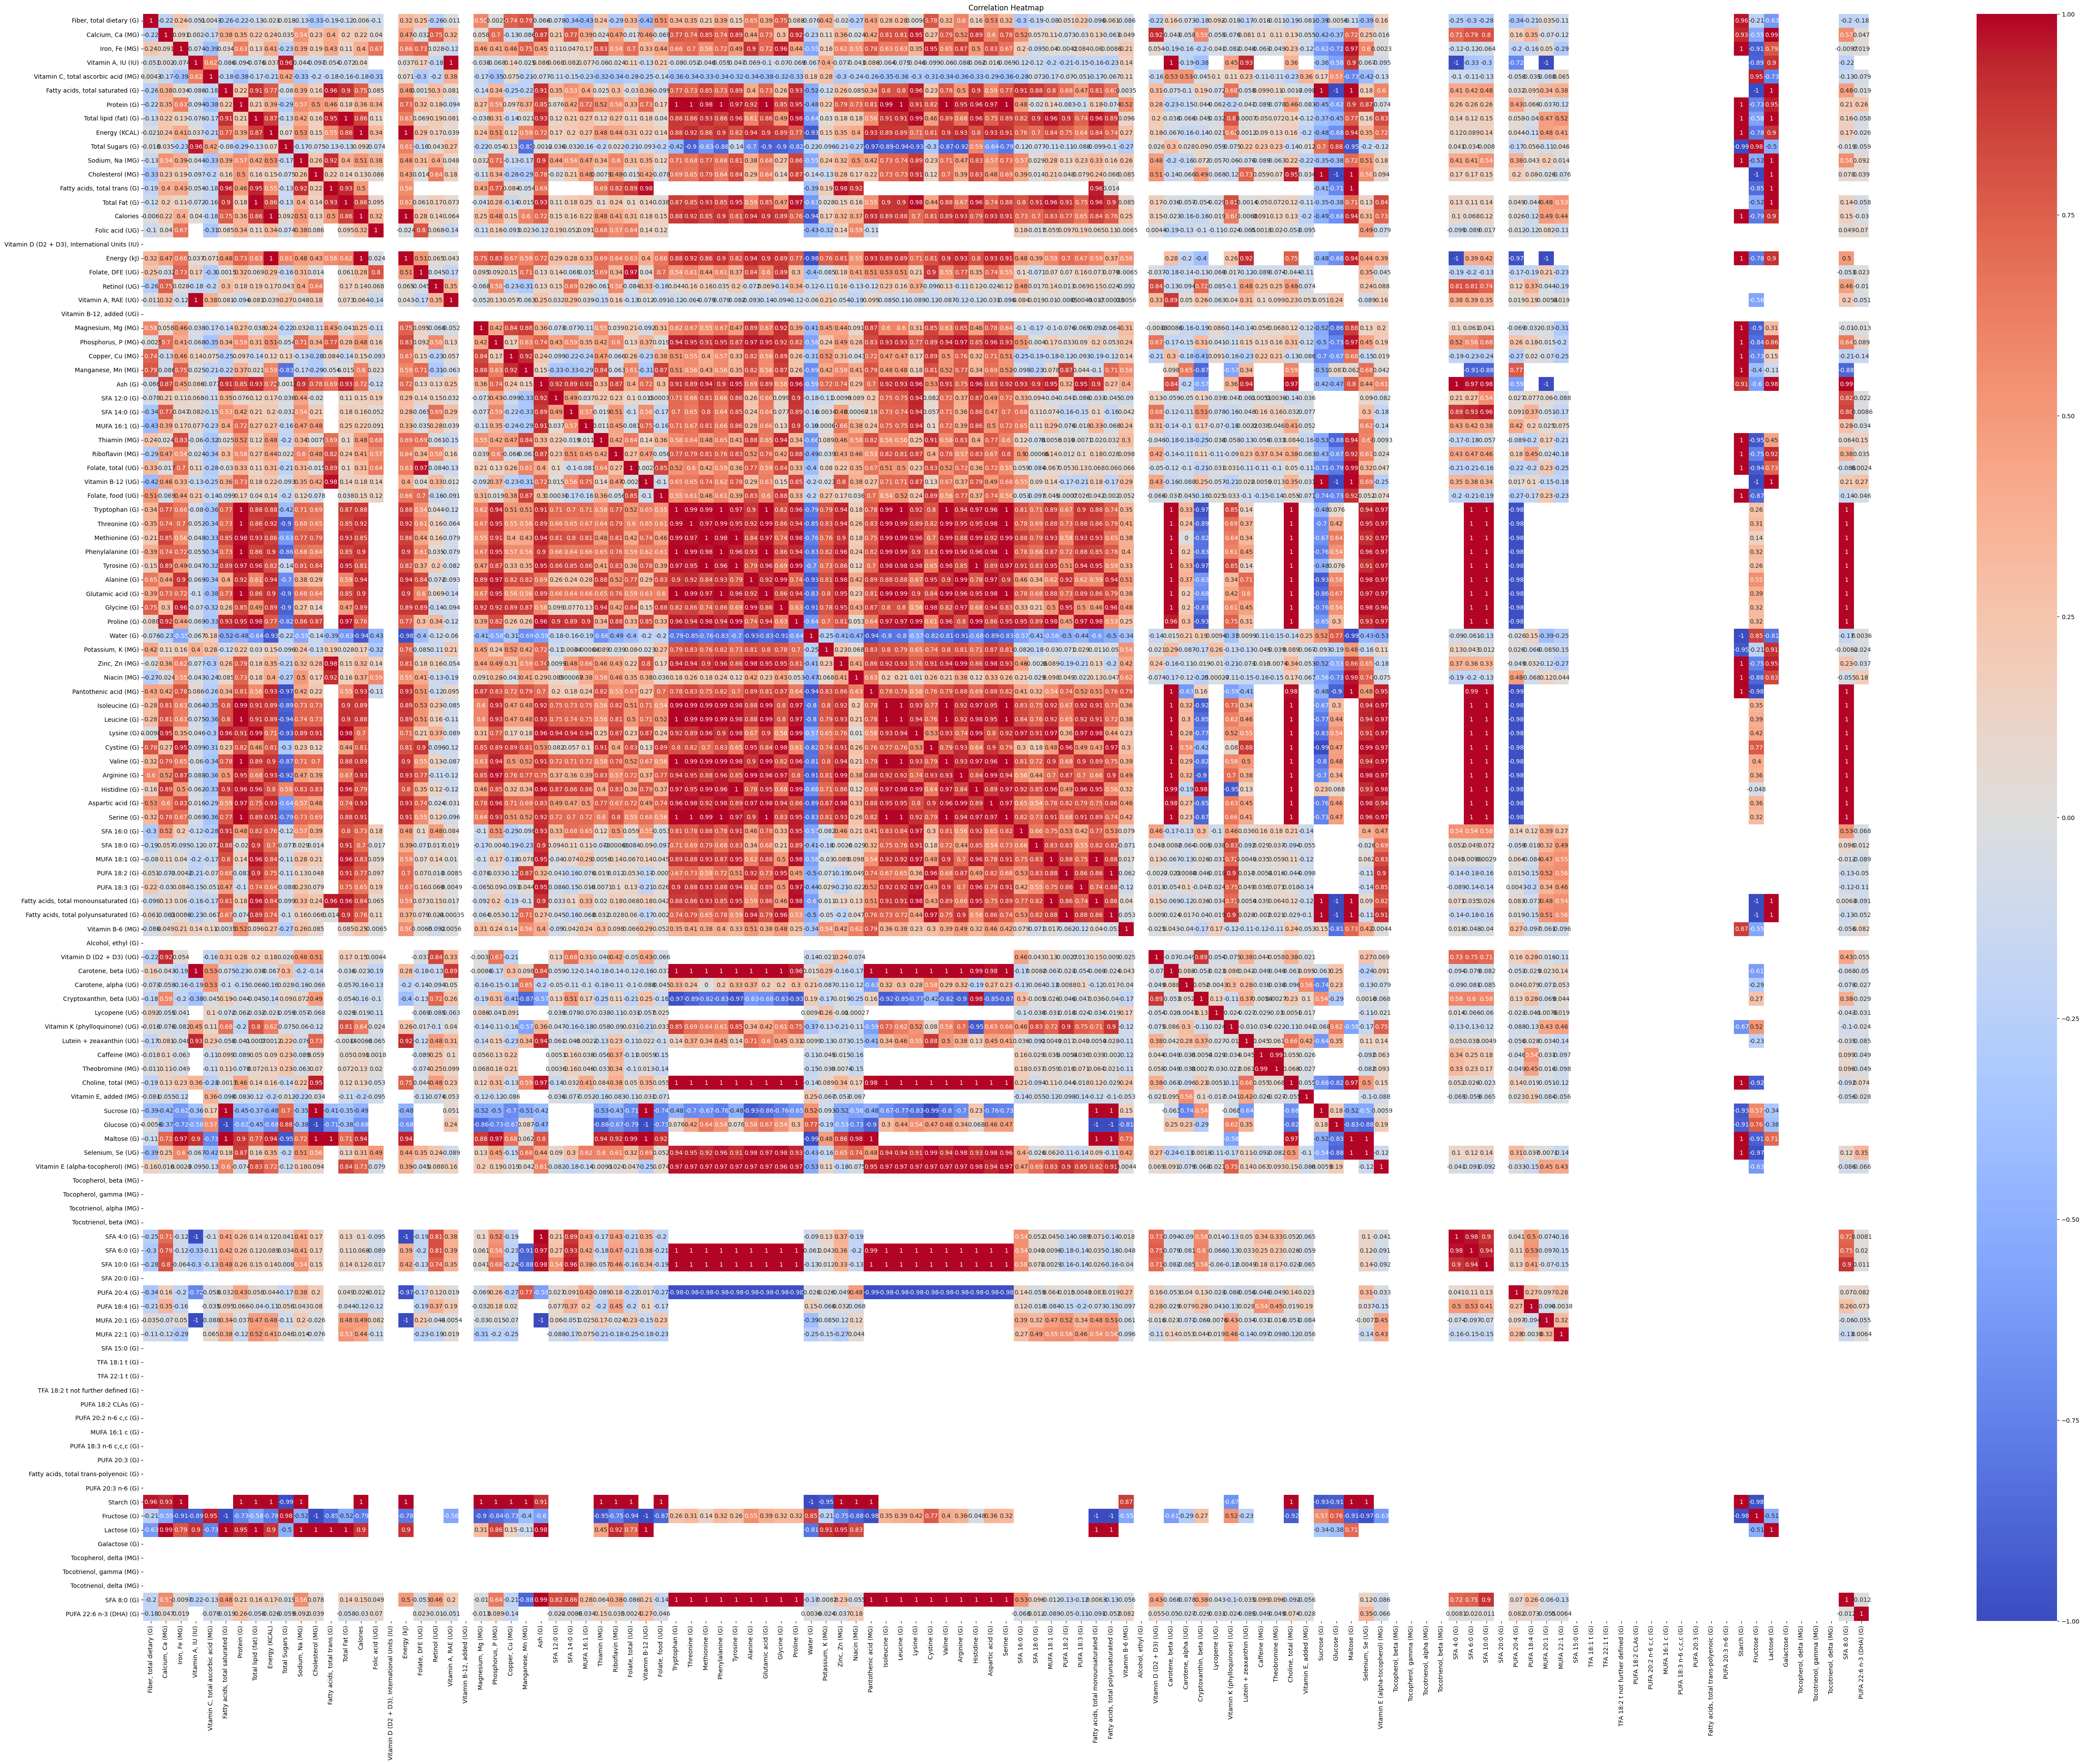

In [ ]:
import seaborn as sns
only_nutrients_other = other_cleaned[other_cleaned.columns[32:147]]
only_nutrients_other.head()
correlation_matrix = only_nutrients_other.corr()
plt.figure(figsize=(64, 48))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') s
plt.title('Correlation Heatmap')
plt.show()

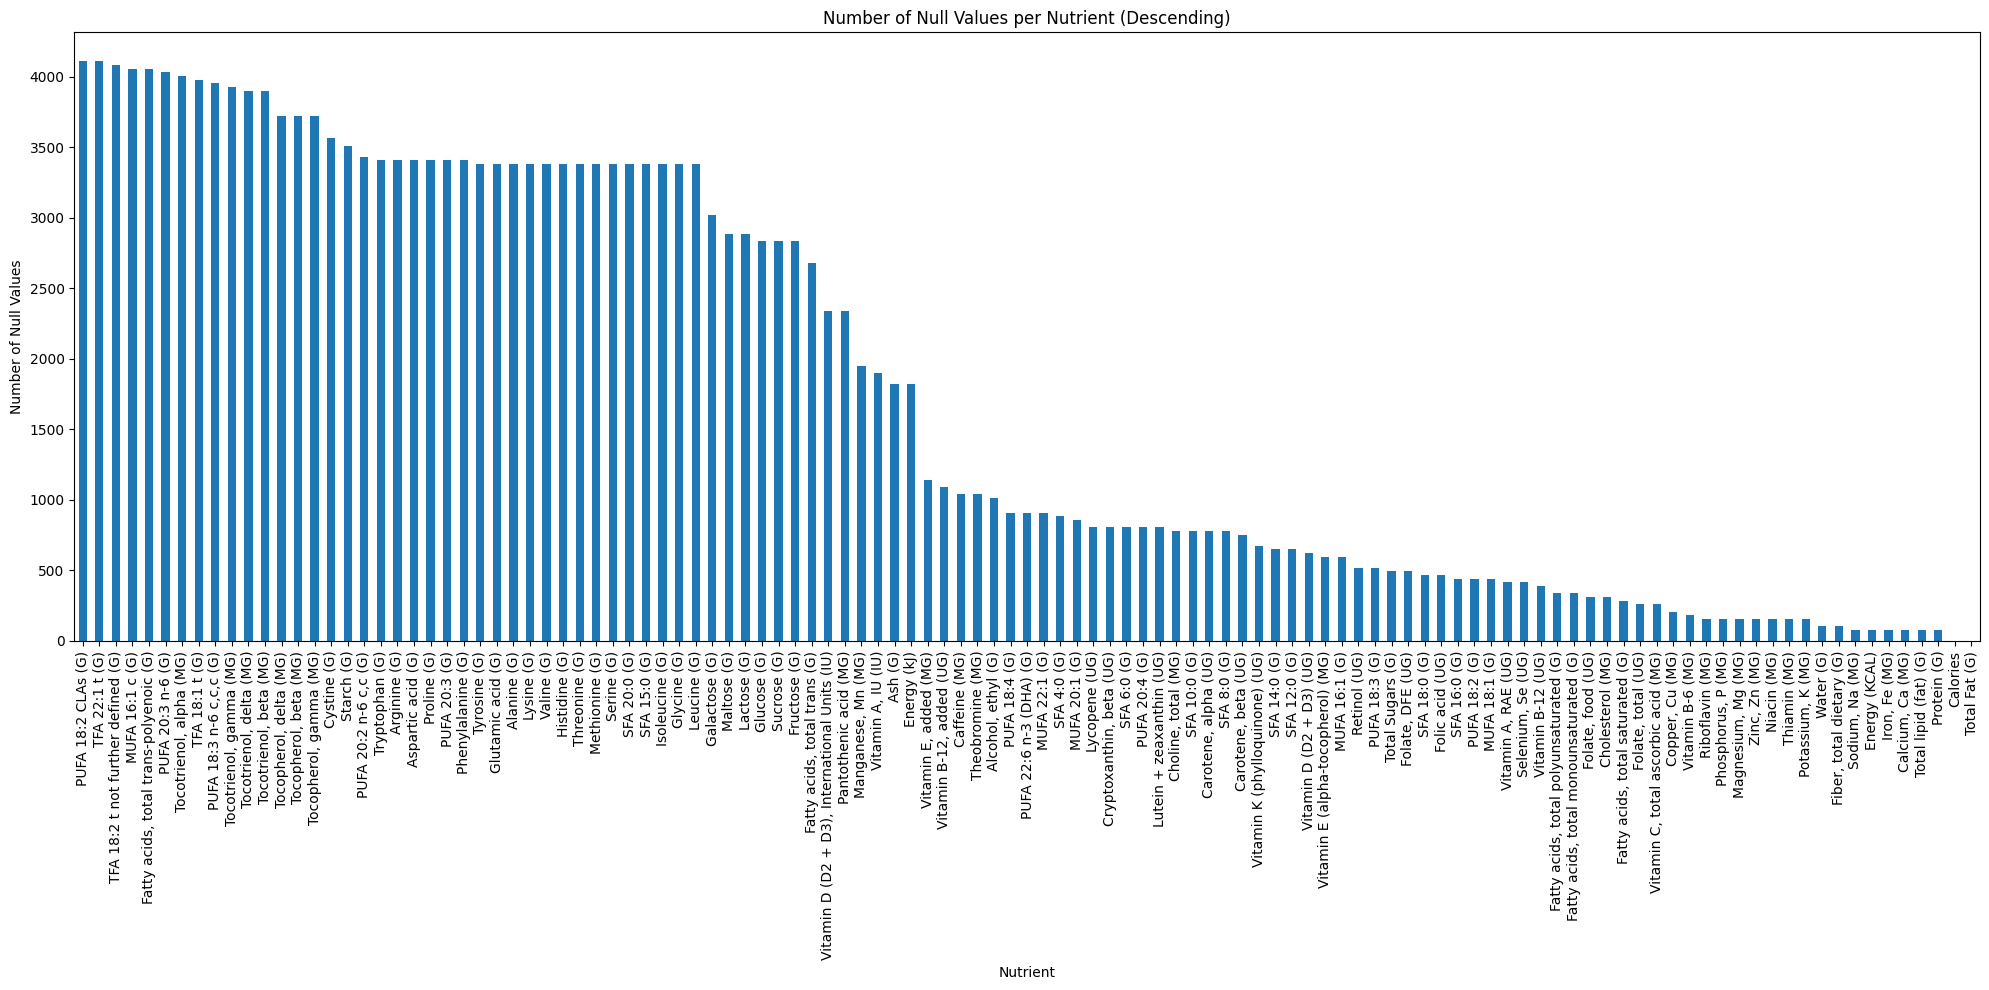

In [ ]:
# Calculate the number of null values per nutrient column
null_counts = other_df[other_df.columns[32:147]].isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
plt.figure(figsize=(20, 10))
null_counts_sorted.plot(kind='bar')
plt.xlabel('Nutrient')
plt.ylabel('Number of Null Values')
plt.title('Number of Null Values per Nutrient (Descending)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()